In [6]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, SeparableConv2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers


In [7]:
patient_details = pd.read_csv('final.csv',na_values='na') #149,553
patient_details = patient_details[patient_details.Inclusion != 'N']
patient_details = patient_details[patient_details.Inclusion != '?']
patient_details = patient_details[patient_details.SOPInstanceUID != '765670-000013/Study-DX-20201021T151236-3361/Series-1428/Image-1.dcm']
patient_details = patient_details[patient_details.SOPInstanceUID != '765670-000031/Study-DX-20211013T024624-3315/Series-1204/Image-1.dcm']
patient_details = patient_details[patient_details.SOPInstanceUID != '765670-000035/Study-DX-20220408T142903-5295/Series-9820/Image-1.dcm']
patient_details = patient_details[patient_details.SOPInstanceUID != '765670-000854/Study-CR-20120912T144547-1844/Series-5/Image-1.dcm']
patient_details = patient_details.reset_index()
patient_details

,index,Inclusion,SOPInstanceUID,InterstitialSym,AirSpaceAsym
0,0,Y,765670-000003/Study-CR-20190223T103423-1061/Se...,0,0
1,1,Y,765670-000004/Study-DX-20140710T133651-2839/Se...,0,0
2,2,Y,765670-000007/Study-DX-20150611T205230-2909/Se...,1,0
3,3,Y,765670-000009/Study-DX-20210623T203125-3261/Se...,0,0
4,6,Y,765670-000012/Study-DX-20121229T200724-1715/Se...,0,0
...,...,...,...,...,...
442,693,Y,765670-001640/Study-DX-20150225T222633-3273/Se...,1,0
443,694,Y,765670-001642/Study-DX-20150831T124935-3081/Se...,0,0
444,697,Y,765670-001648/Study-DX-20130418T155532-6068/Se...,0,0
445,698,Y,765670-001649/Study-DX-20180125T005728-1926/Se...,0,0


In [8]:
train_image = []
image_label = []
test_image = []
test_image_label = []

path = 'E:/cleanedCropped_jpg/train'
imgs = os.listdir(path)

for index, row in patient_details.iterrows():
    Labels = row['InterstitialSym']
    image_label.append(Labels)

for i in range(len(imgs)):
    img_name = "E:/cleanedCropped_jpg/train/" + imgs[i]
    img = cv2.imread(img_name)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    label = image_label[i]
    train_image.append([img,label])


path2 = 'E:/cleanedCropped_jpg/test'
imgs2 = os.listdir(path2)

test_image_label = image_label[358:447]
for i in range(len(imgs2)):
    img_name = "E:/cleanedCropped_jpg/test/" + imgs2[i]
    img = cv2.imread(img_name)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    label = test_image_label[i]
    test_image.append([img,label])

len(test_image)



89

In [9]:
X_train= []
y_train = []
X_test = []
y_test = []

for features,labels in train_image:
    X_train.append(features)
    y_train.append(labels)
for features,labels in test_image:
    X_test.append(features)
    y_test.append(labels)

In [10]:
X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications.resnet import preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50


model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [12]:
from keras.models import Model

output_resnet50_conv = model_resnet50_conv(resnet50_input)
x = Flatten(name='flatten')(output_resnet50_conv)
x = Dense(2, activation='softmax', name='predictions')(x)
resnet50_pretrained = Model(inputs = resnet50_input, outputs = x)
resnet50_pretrained.summary()
sgd = optimizers.SGD(lr = 0.00001)
resnet50_pretrained.compile(loss='binary_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 23,735,298
Non-trainable params: 53,120
_________________________________________________________________


In [40]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)  
datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)


resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer],
                                                            epochs = 60, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/60
6/5 [================================] - ETA: -3s - loss: 1.8732 - accuracy: 0.3827
Epoch 1: val_loss improved from inf to 1.66957, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
5/5 [==============================] - 61s 10s/step - loss: 1.8732 - accuracy: 0.3827 - val_loss: 1.6696 - val_accuracy: 0.3371
Epoch 2/60
6/5 [================================] - ETA: -3s - loss: 1.4618 - accuracy: 0.4637
Epoch 2: val_loss improved from 1.66957 to 1.45496, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
5/5 [==============================] - 56s 10s/step - loss: 1.4618 - accuracy: 0.4637 - val_loss: 1.4550 - val_accuracy: 0.4270
Epoch 3/60
6/5 [================================] - ETA: -3s - loss: 1.3441 - accuracy: 0.5056
Epoch 3: val_loss improved from 1.45496 to 1.32402, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
5/5 [==============================] - 55s 10s/step - loss: 1.3441 - accuracy: 0.5056 - val_loss: 1.3240 - val_accurac

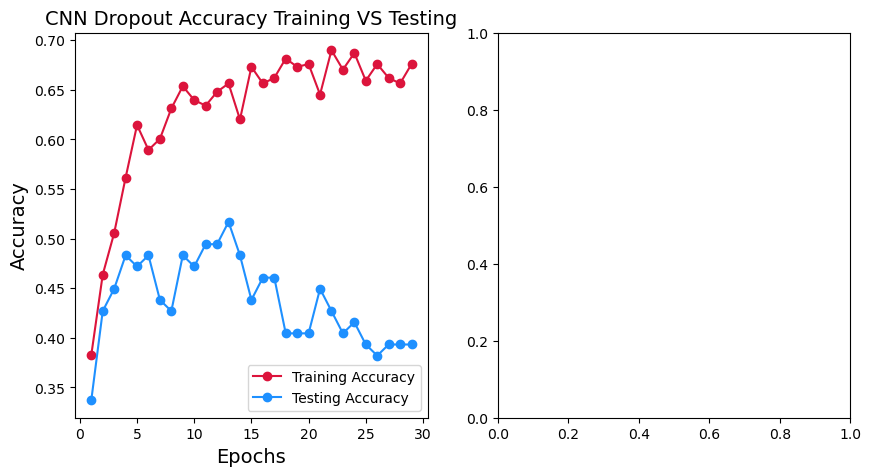

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Training VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')


In [42]:
pred = resnet50_pretrained.predict(X_test,batch_size=16)
pred = np.argmax(pred, axis=-1)


orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(pred.shape)

6/6 [==============================] - 4s 538ms/step
(89,)
(89,)


In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm  = confusion_matrix(orig_test_labels, pred)
cm

array([[31, 46,  4],
       [ 2,  4,  1],
       [ 0,  1,  0]], dtype=int64)

<AxesSubplot:>

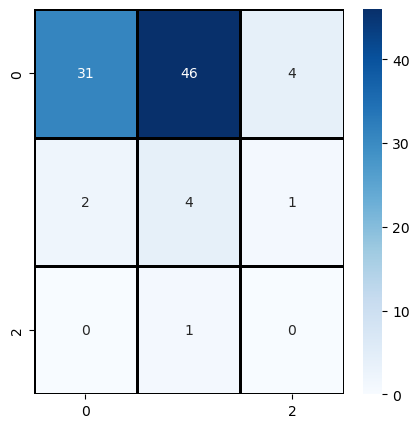

In [46]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


In [13]:
from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
#Use the generated model 
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(inputs = vgg16_input, outputs = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 predictions (Dense)         (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 14,764,866
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
data_generator = datagen.flow(X_train, y_train, batch_size = 64)
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
6/5 [================================] - ETA: -13s - loss: 3.1097 - accuracy: 0.6564
Epoch 1: val_loss improved from inf to 0.46400, saving model to vgg_weights_aug_setval_sgd.hdf5
5/5 [==============================] - 222s 39s/step - loss: 3.1097 - accuracy: 0.6564 - val_loss: 0.4640 - val_accuracy: 0.8764
Epoch 2/25
6/5 [================================] - ETA: -13s - loss: 0.5463 - accuracy: 0.7654
Epoch 2: val_loss improved from 0.46400 to 0.44266, saving model to vgg_weights_aug_setval_sgd.hdf5
5/5 [==============================] - 212s 39s/step - loss: 0.5463 - accuracy: 0.7654 - val_loss: 0.4427 - val_accuracy: 0.8764
Epoch 3/25
1/5 [====>.........................] - ETA: 2:47 - loss: 0.5639 - accuracy: 0.7656

KeyboardInterrupt: 